In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import timeit
import h5py
from pathlib import Path
import numpy as np
from itertools import product, count
import pickle
import scipy.special
import scipy.stats
from math import exp
import multiprocessing
import functools


from FKMC.montecarlo import *

%matplotlib inline
np.seterr(all='warn')
textwidth = 6.268
mpl.rcParams['figure.dpi'] = 70
default_figargs = dict(figsize = (textwidth,textwidth))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


To check the sanity of the monte carlo routine, the above plot compares the boltzman factor $exp(-\beta F) $ for each state of a small system (N=6) with the number of occurances seen during a monte carlo run. Each column shows these factors after an increasing number of montecarlo steps. Each row represents the states by a differnt measure, first they're simply ordered by increasing free energy, second they're plotted against free energy so that degernate states clump together. The 3rd and 4th show the overall occupation $Nf + Nc$ and the squared staggered magnetisation. 

The above plot shows the mean of each observable after x monte carlo steps, showing gradual convergence. Currently the Ff, Fc and Nc observables don't converge to the correct values!

In [4]:
#%%time
from time import time
from FKMC.general import index_histogram

In [7]:
from time import time
t0 = time()
Ns = [8,16,32,64,128,256]
parameters = dict(t = 1, alpha = 1.5, mu = 0, beta = 1/1.1, J = 5, U = 5, normalise = True)
n_bins = 700
MCMC_params = dict(
        N_steps = int(0.01 * 1000),
        N_burn_in = int(0.01 * 1000), 
        logger = Eigenspectrum_IPR_all(bins = n_bins, limit = 5),
        proposal = p_multi_site_poisson_reflect,
        proposal_args = dict(lam = 1),
        accept_function = perturbation_accept,
        warnings = True,
    )

def compute(N, **kwargs):
    t0 = time()
    kwargs['state'] = np.arange(N) % 2
    bins, E, dE, IPR, dIPR = FK_mcmc_2(**kwargs)
    print(f'N = {N} in t = {time() - t0:.0f} seconds')
    return bins[:-1], E, dE, IPR, dIPR

In [8]:
data = np.zeros(shape = (len(Ns), 5, n_bins))

with multiprocessing.Pool(3) as pool:
    curried = functools.partial(compute, parameters = parameters, **MCMC_params)
    data = np.array(pool.map(curried, Ns))


#np.savez('./pickled_data/IPRs_3.npz', 
#        Ns=Ns, parameters = parameters, MCMC_params=MCMC_params, data=data, allow_pickle = True, time = time() - t0,
#        )
print('done')

/home/tch14/FKMC/FKMC/montecarlo.py:283: RuntimeWarning: underflow encountered in square
  IPRs = ((evecs * np.conj(evecs))**2).sum(axis = 0)
/home/tch14/FKMC/FKMC/montecarlo.py:283: RuntimeWarning: underflow encountered in multiply
  IPRs = ((evecs * np.conj(evecs))**2).sum(axis = 0)


TypeError: 'Eigenspectrum_IPR_all' object is not iterable

/workspace/tch14/conda-envs/cmth_intelpython3_2/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


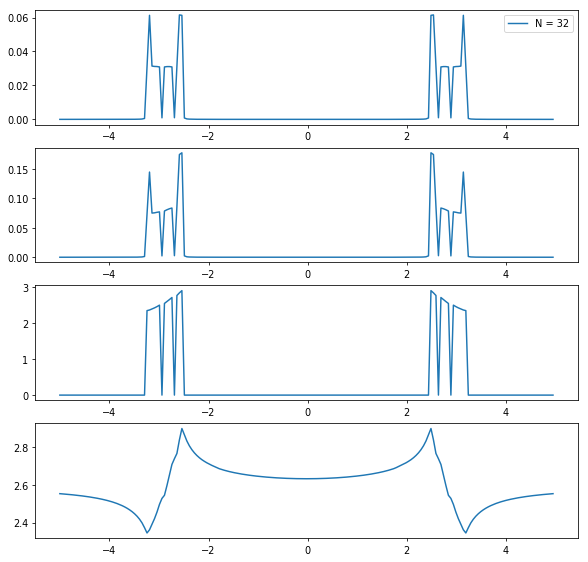

In [29]:
from general import smooth


f, (Eax, Iax, pnIax, nIax) = plt.subplots(4,1, figsize  = (10,10))
for i, col, N in zip(count(), colors, Ns):
    state = np.arange(N)%2
    parameters = dict(t = 1, alpha = 1.5, mu = 0, beta = 1/1.1, J = 5, U = 5, normalise = True)
    J_matrix = interaction_matrix(state.shape[0], **parameters)
    Ff, Fc, evals, evecs = solve_H(state, J_matrix=J_matrix, **parameters)
    IPRs = ((evecs * np.conj(evecs))**2).sum(axis = 0)

    bins = np.linspace(-5,5,200)
    E, _, indices = index_histogram(bins, evals)
    IPR = np.bincount(indices, weights=IPRs, minlength = bins.shape[0] + 1)[1:-1]
    bins = bins[:-1]
    E = E/N
    
    scale = 0.1
    pre_normed_IPR = np.where(E > 0, IPR / E, 0)
    
    E = smooth(E, scale)
    IPR = smooth(IPR, scale)
    
    normed_IPR = np.where(E > 0, IPR / E, 0)
    
    Eax.plot(bins, E, label = f'N = {N}')
    Iax.plot(bins, IPR)
    pnIax.plot(bins, pre_normed_IPR)
    nIax.plot(bins, normed_IPR)
    
    
Eax.legend()

Ns = [  8  16  32  64 128 256]
parameters = {'t': 1, 'alpha': 1.5, 'mu': 0, 'beta': 0.9090909090909091, 'J': 5, 'U': 5, 'normalise': True}
MCMC_params = {'N_steps': 50000, 'N_burn_in': 1000, 'logger': <montecarlo.Eigenspectrum_IPR object at 0x7f4f7ec7b4e0>, 'proposal': <function p_multi_site_poisson_reflect at 0x7f4f80109730>, 'proposal_args': {'lam': 1}, 'accept_function': <function perturbation_accept at 0x7f4f801099d8>, 'warnings': True}
time = 23274.325165510178


/workspace/tch14/conda-envs/cmth_intelpython3_2/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/workspace/tch14/conda-envs/cmth_intelpython3_2/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/workspace/tch14/conda-envs/cmth_intelpython3_2/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


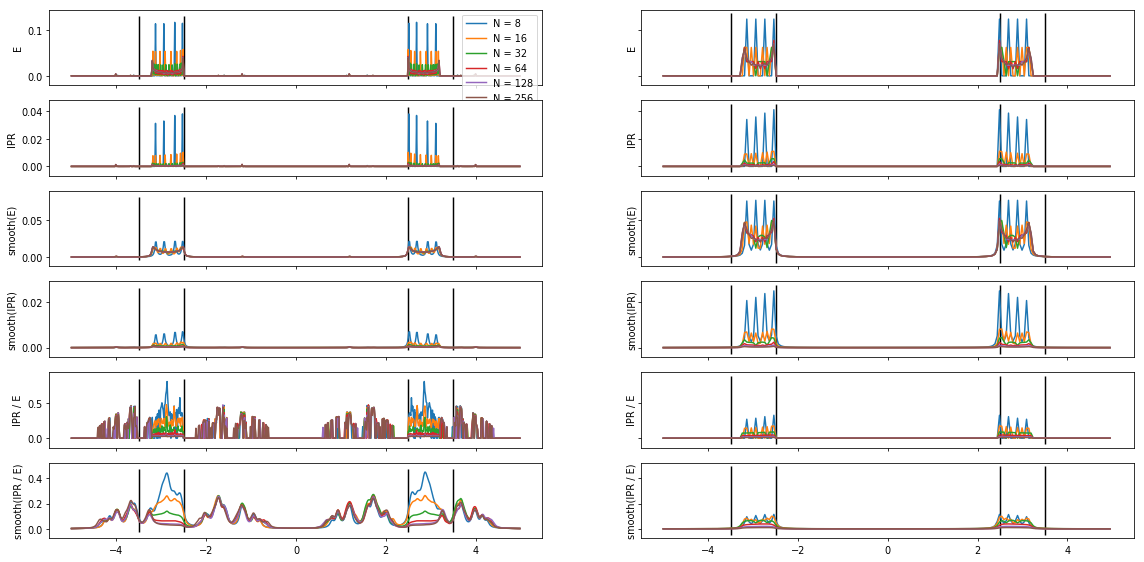

In [17]:
from general import smooth
from itertools import count

def plot_IPRs(file_name):
    p = np.load(file_name, allow_pickle = True)
    
    for k,v in p.items():
        if k != 'data': print(f'{k} = {v}')

    f, axes = plt.subplots(6,2, figsize  = (20,10), sharex = 'all', sharey = 'row')
    for j, ax in zip(count(), axes.T):
        for i, col, N, Nslice in zip(count(), colors, p['Ns'], p['data']):

            if j == 0:
                bins, E, dE, IPR, dIPR = Nslice
            else:
                state = np.arange(N)%2
                parameters = dict(t = 1, alpha = 1.5, mu = 0, beta = 1/1.1, J = 5, U = 5, normalise = True)
                J_matrix = interaction_matrix(state.shape[0], **parameters)
                Ff, Fc, evals, evecs = solve_H(state, J_matrix=J_matrix, **parameters)
                IPRs = ((evecs * np.conj(evecs))**2).sum(axis = 0)

                bins = np.linspace(-5,5,200)
                E, _, indices = index_histogram(bins, evals)
                IPR = np.bincount(indices, weights=IPRs, minlength = bins.shape[0] + 1)[1:-1]
                bins = bins[:-1]
                E = E/N

            IPR = IPR / N

            scale = 2
            pre_normed_IPR = np.where(E > 0, IPR / E, 0)

            sE = smooth(E, scale)
            sIPR = smooth(IPR, scale)

            normed_IPR = np.where(sE > 0, sIPR / sE, 0)

            ax[0].plot(bins, E, label = f'N = {N}')
            ax[0].set(ylabel = 'E')


            ax[1].plot(bins, IPR)
            ax[1].set(ylabel = 'IPR')

            ax[2].plot(bins, smooth(E, scale = 0.5))
            ax[2].set(ylabel = 'smooth(E)')

            ax[3].plot(bins, smooth(IPR, scale = 0.5))
            ax[3].set(ylabel = 'smooth(IPR)')

            normed_IPR = np.where(E > 0, IPR / E, 0)
            ax[4].plot(bins,  normed_IPR)
            ax[4].set(ylabel = 'IPR / E')#, ylim = (-0.1, 20))

            normed_IPR = smooth(np.where(E > 0, IPR / E, 0), scale = 1)
            ax[5].plot(bins,  normed_IPR)
            ax[5].set(ylabel = 'smooth(IPR / E)')#, ylim = (-0.1, 20))
    
    
    U, t = parameters['U'], parameters['t']
    for a in axes.flatten(): a.vlines([-t-U/2,-U/2,U/2,U/2+t],*a.get_ylim())

    axes[0,0].legend()
    #axes[0,0].set(xlim = (-4, 0))
    
plot_IPRs('./pickled_data/IPRs_3.npz')

(6, 5, 700)
Ns = [  8  16  32  64 128]
parameters = {'t': 1, 'alpha': 1.5, 'mu': 0, 'beta': 0.9090909090909091, 'J': 5, 'U': 5, 'normalise': True}
MCMC_params = {'N_steps': 10000, 'N_burn_in': 1000, 'logger': <__main__.Eigenspectrum_IPR object at 0x7fa742f89e48>, 'proposal': <function p_multi_site_poisson_reflect at 0x7fa748085158>, 'proposal_args': {'lam': 1}, 'accept_function': <function perturbation_accept at 0x7fa748085400>}


/workspace/tch14/conda-envs/cmth_intelpython3_2/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/workspace/tch14/conda-envs/cmth_intelpython3_2/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
/workspace/tch14/conda-envs/cmth_intelpython3_2/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


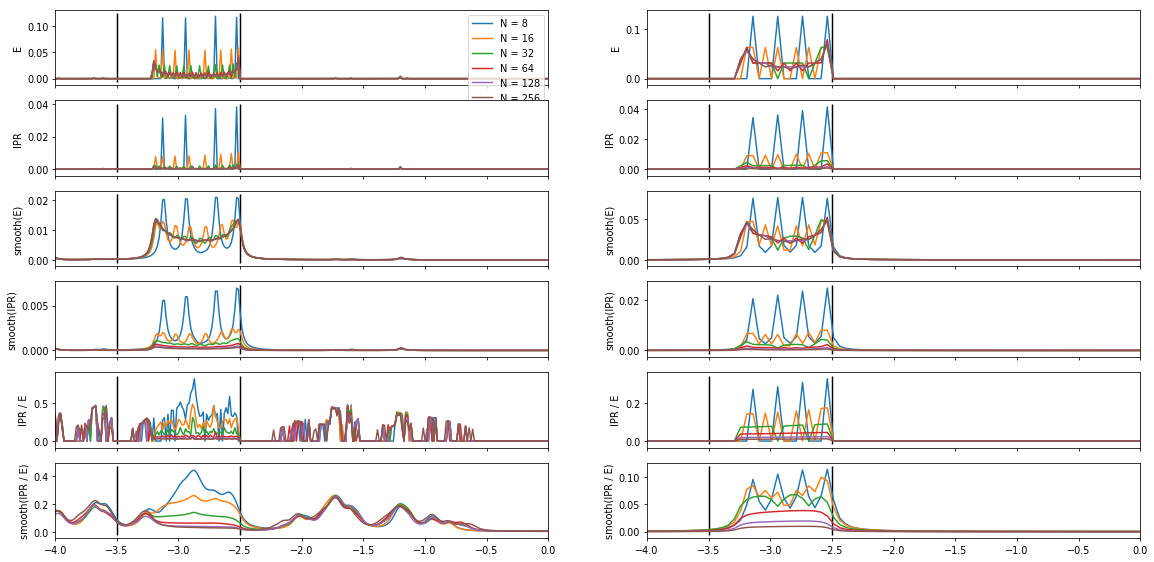

Ns = [256 128  64  32]
parameters = {'t': 1, 'alpha': 1.5, 'mu': 0, 'beta': 0.9090909090909091, 'J': 5, 'U': 5, 'normalise': True}
MCMC_params = {'N_steps': 5000, 'N_burn_in': 1000, 'logger': <montecarlo.Eigenspectrum_IPR object at 0x7f4f7c17c940>, 'proposal': <function p_multi_site_poisson_reflect at 0x7f4f80109730>, 'proposal_args': {'lam': 1}, 'accept_function': <function perturbation_accept at 0x7f4f801099d8>, 'warnings': True}


/workspace/tch14/conda-envs/cmth_intelpython3_2/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/workspace/tch14/conda-envs/cmth_intelpython3_2/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/workspace/tch14/conda-envs/cmth_intelpython3_2/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


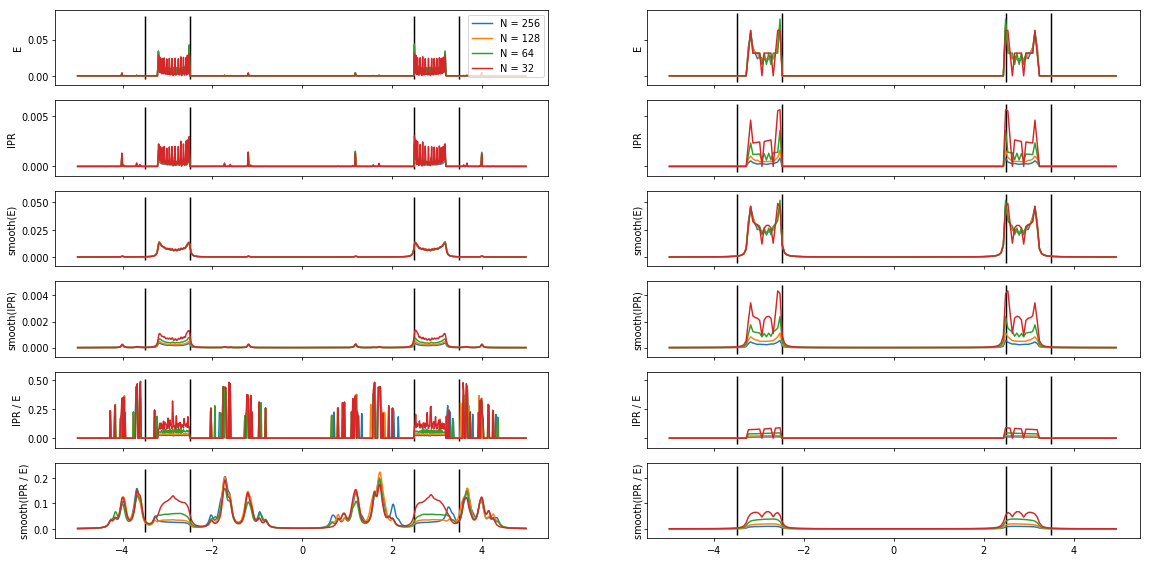

In [18]:
plot_IPRs('./pickled_data/IPRs_2.npz')

Ns = [256 128  64  32]
parameters = {'t': 1, 'alpha': 1.5, 'mu': 0, 'beta': 0.9090909090909091, 'J': 5, 'U': 5, 'normalise': True}
MCMC_params = {'N_steps': 5000, 'N_burn_in': 1000, 'logger': <montecarlo.Eigenspectrum_IPR object at 0x7f4f7ec53dd8>, 'proposal': <function p_multi_site_poisson_reflect at 0x7f4f80109730>, 'proposal_args': {'lam': 1}, 'accept_function': <function perturbation_accept at 0x7f4f801099d8>, 'warnings': True}


/workspace/tch14/conda-envs/cmth_intelpython3_2/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/workspace/tch14/conda-envs/cmth_intelpython3_2/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/workspace/tch14/conda-envs/cmth_intelpython3_2/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


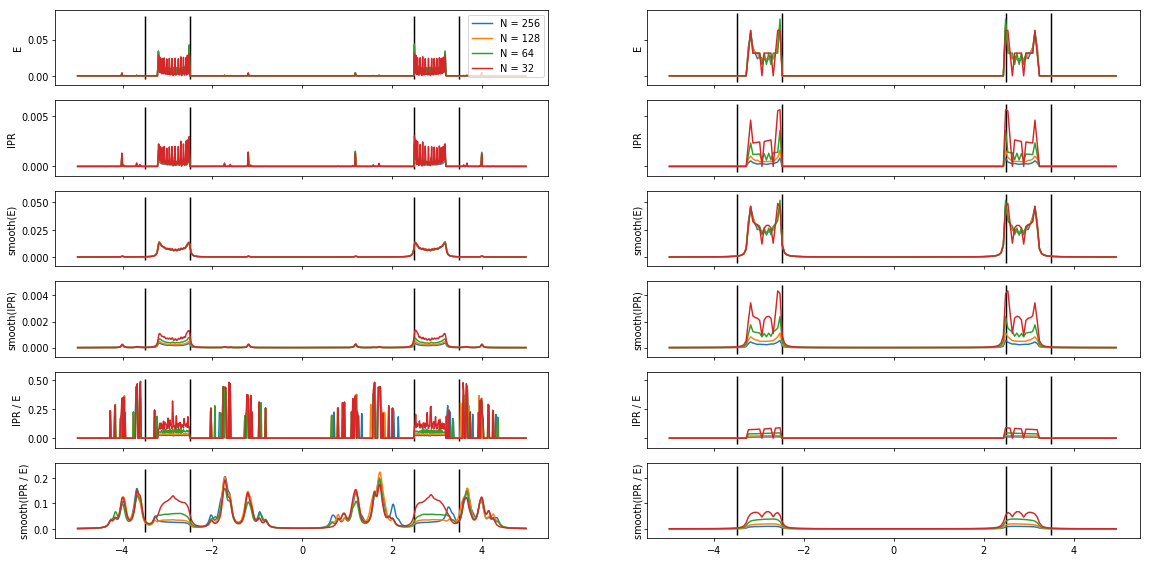

In [43]:
plot_IPRs('./pickled_data/IPRs_2.npz')

Ns = [  8  16  32  64 128 256]
parameters = {'t': 1, 'alpha': 1.5, 'mu': 0, 'beta': 0.9090909090909091, 'J': 5, 'U': 5, 'normalise': True}
MCMC_params = {'N_steps': 50000, 'N_burn_in': 1000, 'logger': <montecarlo.Eigenspectrum_IPR object at 0x7f4f7c14b0f0>, 'proposal': <function p_multi_site_poisson_reflect at 0x7f4f80109730>, 'proposal_args': {'lam': 1}, 'accept_function': <function perturbation_accept at 0x7f4f801099d8>, 'warnings': True}
time = 23274.325165510178


/workspace/tch14/conda-envs/cmth_intelpython3_2/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/workspace/tch14/conda-envs/cmth_intelpython3_2/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


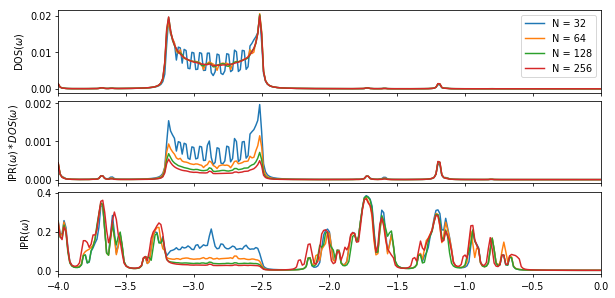

In [46]:
def plot_IPRs_2(file_name):
    p = np.load(file_name, allow_pickle = True)
    
    for k,v in p.items():
        if k != 'data': print(f'{k} = {v}')

    f, ax = plt.subplots(3,1, figsize  = (10,5), sharex = 'all', gridspec_kw = dict(hspace = 0.1, wspace = 0))
    
    for i, col, N, Nslice in zip(count(), colors, p['Ns'], p['data']):
        if N < 32: continue
        bins, E, dE, IPR, dIPR = Nslice

        IPR = IPR / N

        scale = 0.2
        pre_normed_IPR = np.where(E > 0, IPR / E, 0)

        sE = smooth(E, scale)
        sIPR = smooth(IPR, scale)

        normed_IPR = np.where(sE > 0, sIPR / sE, 0)

        ax[0].plot(bins, sE, label = f'N = {N}')
        ax[0].set(ylabel = r'DOS$(\omega)$')

        ax[1].plot(bins, sIPR)
        ax[1].set(ylabel = r'IPR$(\omega) * DOS(\omega)$')

        normed_IPR = smooth(np.where(E > 0, IPR / E, 0), scale)
        ax[2].plot(bins,  normed_IPR)
        ax[2].set(ylabel = r'IPR$(\omega)$')#, ylim = (-0.1, 20))



    ax[0].legend()
    ax[0].set(xlim = (-4, 0))
    
plot_IPRs_2('./pickled_data/IPRs_3.npz')